# Lecture : Graph SVM

## Lab 01 : Standard/Linear SVM -- Exercise

### Xavier Bresson, Guoji Fu 


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/04_Graph_SVM'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [2]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook 
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from IPython.display import display, clear_output
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_purity
import warnings; warnings.filterwarnings("ignore")


# Linearly separable data points

In [3]:
# Dataset
mat = scipy.io.loadmat('datasets/data_linearSVM.mat')
Xtrain = mat['Xtrain']
Cgt_train = mat['Cgt_train'] - 1; Cgt_train = Cgt_train.squeeze()
l_train = mat['l'].squeeze()
n = Xtrain.shape[0]
d = Xtrain.shape[1]
nc = len(np.unique(Cgt_train))
print(n,d,nc)
Xtest = mat['Xtest']
Cgt_test = mat['Cgt_test'] - 1; Cgt_test = Cgt_test.squeeze()


40 2 2


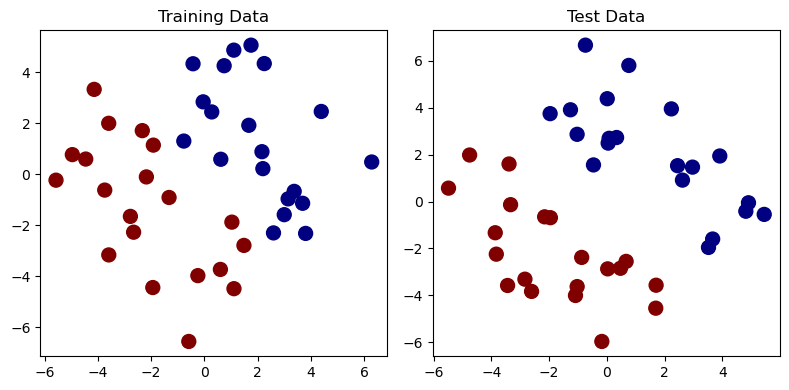

In [4]:
# Plot
plt.figure(figsize=(8,4))
p1 = plt.subplot(121)
size_vertex_plot = 100
plt.scatter(Xtrain[:,0], Xtrain[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_train, color=pyplot.jet())
plt.title('Training Data')
p2 = plt.subplot(122)
size_vertex_plot = 100
plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_test, color=pyplot.jet())
plt.title('Test Data')
plt.tight_layout()
plt.show()


### Question 1: Implement the linear SVM on linear separable data using the primal-dual iterative algorithm

*Hint:* Follow Page 18-20, Lecture 4 Slides

**Step 1:** Compute the Linear Kernel $Ker$ and $L, Q$ defined as
- $Ker= XX^\top$,
- $L = \text{diag}(l)$, 
- $Q = LKL$.
 
You may use function `np.diag()`, the transpose operator `.T`, and the matrix-matrix multiplication operator `.dot()`.
  

In [5]:
# Compute linear kernel, L, Q

l = l_train

############################################################################
# Your code start
############################################################################
# X_train shape: 40 x 2 [n x k]
# Ker Shape: 40 x 40 [n x n]
# L Shape: 40 x 40 [n x n]
# Q Shape: 40 x 40 [n x n]

Ker = Xtrain.dot(Xtrain.T) # X^T X
L = np.diag(l)
Q = L.dot(Ker.dot(L))

############################################################################
# Your code end
############################################################################


**Step 2:** Initialize $\alpha^{k=0} = \beta^{k=0} = 0_n$.

You may use function `np.zeros()` for initializing a zero vector.


In [6]:
# Initialization
############################################################################
# Your code start
############################################################################
# O_n = 1D array of 0s of size n
alpha = np.zeros(n) # Shape: n x 1
beta = np.zeros(n) # Shape: n x 1
print(beta.shape)
############################################################################
# Your code end
############################################################################


(40,)


**Step 3:** Choose the time steps $\tau_\alpha, \tau_\beta$ such that $\tau_\alpha\tau_\beta \leq \frac{1}{\|Q\| \cdot \|L\|}$.

Some feasible choices can be $\tau_\alpha = \frac{a}{\|Q\|}, \tau_\beta = \frac{b}{\|L\|}$, where $ab \leq 1$.

You may use `np.linalg.norm()` to compute the norm of a matrix.

Try to evaluate the performance of linear SVM with different choices of time steps.
  

In [7]:
# Time steps
############################################################################
# Your code start
############################################################################
# Remember ||x|| is the the same as ||x||_2 
tau_alpha = 1 / np.linalg.norm(Q, ord=2)
tau_beta = 1 / np.linalg.norm(L, ord=2)

############################################################################
# Your code end
############################################################################


**Step 4:** Project alpha to $[0, +\infty]$ during the update of alpha and beta with conjuguate gradient.


(40,) (40, 40)
(40,) (40, 40)
(40,) (40, 40)
(40,) (40, 40)
(40,) (40, 40)
(40,) (40, 40)
(40,) (40, 40)
(40,) (40, 40)
(40,) (40, 40)
(40,) (40, 40)


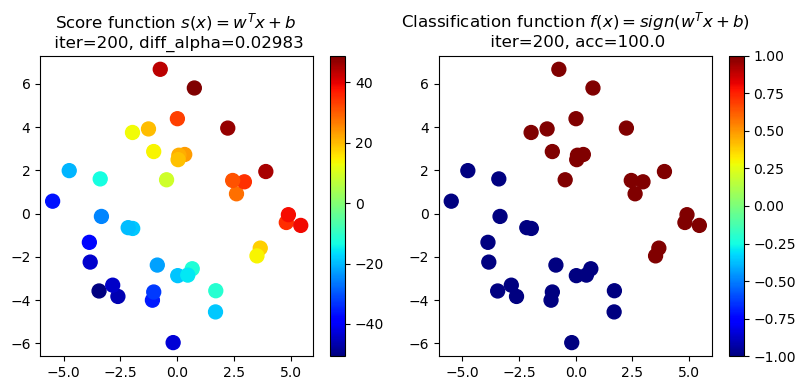

(40,) (40, 40)


In [8]:
# Run Linear SVM

# Compute linear kernel, L, Q
Ker = Xtrain.dot(Xtrain.T)
l = l_train
L = np.diag(l)
Q = L.dot(Ker.dot(L))

# Time steps
tau_alpha = 10/ np.linalg.norm(Q,2)
tau_beta = 0.1/ np.linalg.norm(L,2)

# For conjuguate gradient
Acg = tau_alpha* Q + np.eye(n)

# Pre-compute J.K(Xtest) for test data
LKXtest = L.dot(Xtrain.dot(Xtest.T))

# Initialization
alpha_old = alpha

# Loop
k = 0
diff_alpha = 1e6
num_iter = 201
while (diff_alpha>1e-3) & (k<num_iter):
    
    # Update iteration
    k += 1
    
    # Update alpha
    # Approximate solution with conjuguate gradient
    b0 = alpha + tau_alpha - tau_alpha* l* beta # L and l are the same.
    print(b0.shape, Acg.shape)
    alpha, _ = scipy.sparse.linalg.cg(Acg, b0, x0=alpha, tol=1e-3, maxiter=50)   
    
    # Projection of alpha on [0,+infty]
    ############################################################################
    # Your code start
    ############################################################################
    # Convert negative values to 0
    alpha[alpha<0.0] = 0
    ############################################################################
    # Your code here
    ############################################################################

    # Update beta
    beta = beta + tau_beta* l.T.dot(alpha)
    
    # Stopping condition
    diff_alpha = np.linalg.norm(alpha-alpha_old)
    alpha_old = alpha
    
    # Plot
    if not(k%10) or (diff_alpha<1e-3):
           
        # Indicator function of support vectors
        idx = np.where( np.abs(alpha)>0.25* np.max(np.abs(alpha)) )
        Isv = np.zeros([n]); Isv[idx] = 1
        nb_sv = len(Isv.nonzero()[0])
        
        # Offset
        if nb_sv > 1:
            b = (Isv.T).dot( l - Ker.dot(L.dot(alpha)) )/ nb_sv
        else:
            b = 0
            
        # Continuous score function
        f_test = alpha.T.dot(LKXtest) + b 

        # Binary classification function
        C_test = np.sign(f_test) # decision function in {-1,1}
        accuracy_test = compute_purity(0.5*(1+C_test),Cgt_test,nc) # 0.5*(1+C_test) in {0,1}

        # Plot
        plt.figure(figsize=(8,4))
        p1 = plt.subplot(121)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=f_test, color=pyplot.jet())
        plt.title('Score function $s(x)=w^Tx+b$ \n iter=' + str(k)+ ', diff_alpha=' + str(diff_alpha)[:7])
        plt.colorbar()
        p2 = plt.subplot(122)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=C_test, color=pyplot.jet())
        plt.title('Classification function $f(x)=sign(w^Tx+b)$\n iter=' + str(k) + ', acc=' + str(accuracy_test)[:5])
        plt.tight_layout()
        plt.colorbar()
        plt.show()
        if k<num_iter-1:
            clear_output(wait=True)   
        

# Non-linearly separable data points

In [9]:
# Dataset
mat = scipy.io.loadmat('datasets/data_twomoons_softSVM.mat')
Xtrain = mat['Xtrain']
Cgt_train = mat['C_train_errors'] - 1; Cgt_train = Cgt_train.squeeze()
Cgt_train[:250] = 0; Cgt_train[250:] = 1
l_train = mat['l'].squeeze()
n = Xtrain.shape[0]
d = Xtrain.shape[1]
nc = len(np.unique(Cgt_train))
print(n,d,nc)
Xtest = mat['Xtest']
Cgt_test = mat['Cgt_test'] - 1; Cgt_test = Cgt_test.squeeze()


500 100 2


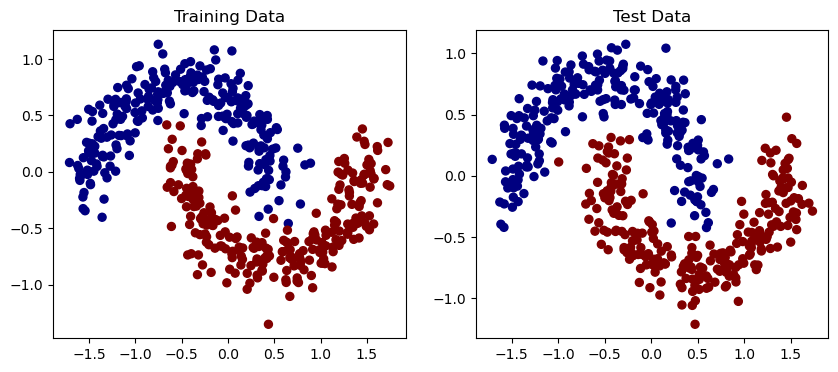

In [10]:
# Plot
plt.figure(figsize=(10,4))
p1 = plt.subplot(121)
size_vertex_plot = 33
plt.scatter(Xtrain[:,0], Xtrain[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_train, color=pyplot.jet())
plt.title('Training Data')
p2 = plt.subplot(122)
size_vertex_plot = 33
plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_test, color=pyplot.jet())
plt.title('Test Data')
#plt.tight_layout()
plt.show()


### Question 2: Compute linear kernel, L, Q, time steps, initialization and projection of alpha as for Question 1

Compare the results with the linearly separable case and determine which performs better. 

Answer: 

What strategy can be used to enhance the performance of SVM on non-linearly separable data?

Answer: 


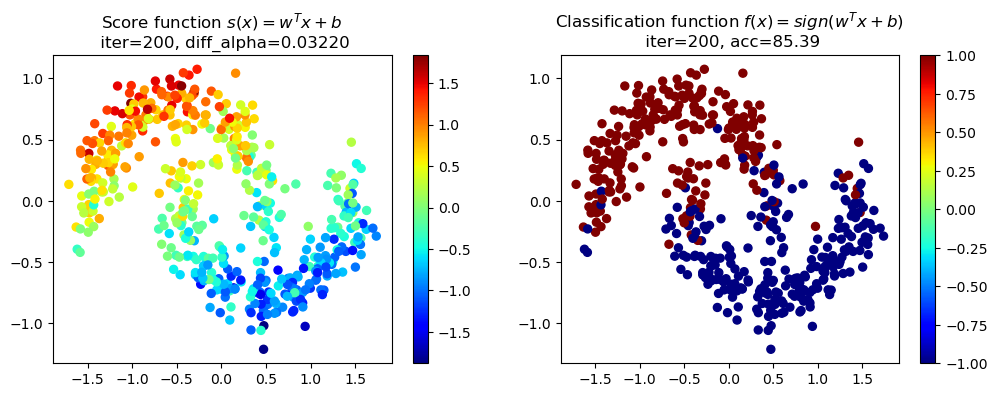

In [11]:
# Run Linear SVM

# Compute linear kernel, L, Q
Ker = Xtrain.dot(Xtrain.T) # YOUR CODE HERE 
l = l_train
L = np.diag(l) # YOUR CODE HERE 
Q = L.dot(Ker.dot(L)) # YOUR CODE HERE 

# Time steps
tau_alpha = 1/ np.linalg.norm(Q,2)# YOUR CODE HERE 
tau_beta = 1/ np.linalg.norm(L,2)# YOUR CODE HERE 

# For conjuguate gradient
Acg = tau_alpha* Q + np.eye(n)

# Pre-compute J.K(Xtest) for test data
LKXtest = L.dot(Xtrain.dot(Xtest.T))

# Initialization
alpha = np.zeros(n) # YOUR CODE HERE 
beta = np.zeros(n) # YOUR CODE HERE 
alpha_old = alpha

# Loop
k = 0
diff_alpha = 1e6
num_iter = 201
while (diff_alpha>1e-3) & (k<num_iter):
    
    # Update iteration
    k += 1
    
    # Update alpha
    # Approximate solution with conjuguate gradient
    b0 = alpha + tau_alpha - tau_alpha* l* beta
    alpha, _ = scipy.sparse.linalg.cg(Acg, b0, x0=alpha, tol=1e-3, maxiter=50)   

    # Projection on [0,+infty]
    alpha# YOUR CODE HERE  

    # Update beta
    beta = beta + tau_beta* l.T.dot(alpha)
    
    # Stopping condition
    diff_alpha = np.linalg.norm(alpha-alpha_old)
    alpha_old = alpha
    
    # Plot
    if not(k%10) or (diff_alpha<1e-3):
           
        # Indicator function of support vectors
        idx = np.where( np.abs(alpha)>0.25* np.max(np.abs(alpha)) )
        Isv = np.zeros([n]); Isv[idx] = 1
        nb_sv = len(Isv.nonzero()[0])
        
        # Offset
        if nb_sv > 1:
            b = (Isv.T).dot( l - Ker.dot(L.dot(alpha)) )/ nb_sv
        else:
            b = 0
            
        # Continuous score function
        f_test = alpha.T.dot(LKXtest) + b 

        # Binary classification function
        C_test = np.sign(f_test) # decision function in {-1,1}
        accuracy_test = compute_purity(0.5*(1+C_test),Cgt_test,nc) # 0.5*(1+C_test) in {0,1}

        # Plot
        size_vertex_plot = 33
        plt.figure(figsize=(12,4))
        p1 = plt.subplot(121)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=f_test, color=pyplot.jet())
        plt.title('Score function $s(x)=w^Tx+b$ \n iter=' + str(k)+ ', diff_alpha=' + str(diff_alpha)[:7])
        plt.colorbar()
        p2 = plt.subplot(122)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=C_test, color=pyplot.jet())
        plt.title('Classification function $f(x)=sign(w^Tx+b)$\n iter=' + str(k) + ', acc=' + str(accuracy_test)[:5])
        #plt.tight_layout()
        plt.colorbar()
        plt.show()
        if k<num_iter-1:
            clear_output(wait=True)   
        